<a href="https://colab.research.google.com/github/kranti-experiments/EVA4/blob/master/S10/s10_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torchsummary import summary
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

#from albumentations.pytorch import ToTensor

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from AlbumentationTransforms import AlbumentationTransform
from dataloader import getDataLoader
from models import resnet18
#import train

In [4]:
if(torch.cuda.is_available):
    device = 'cuda'
else:
    device = 'cpu'

In [5]:
import albumentations as AL
import albumentations.pytorch as AT

In [6]:
train_transform = AlbumentationTransform([
                                       AL.RandomCrop(32, 32),
                                       AL.Rotate((-30.0, 30.0)),
                                       AL.HorizontalFlip(p=0.5),
                                       AL.RandomBrightness(),
                                       AL.RGBShift(r_shift_limit=50, g_shift_limit=50, b_shift_limit=50, p=0.5),
                                       AL.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
                                       AL.Cutout(num_holes=1, max_h_size=16, max_w_size = 16, p=1),
                                       AT.ToTensor()
                                       ])
# Test Phase transformations
test_transform = AlbumentationTransform([AL.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)), AT.ToTensor()])

In [7]:
trainloader, testloader = getDataLoader('CIFAR10', 32, train_transform, test_transform)

Files already downloaded and verified


In [8]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [9]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [10]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

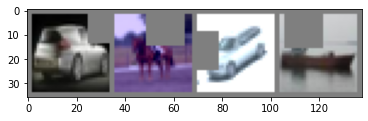

  car horse   car  ship


In [11]:
# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [12]:
dataiter = iter(testloader)
images, labels = dataiter.next()

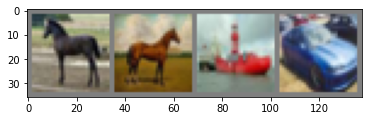

horse horse  ship   car


In [13]:
# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [14]:
net = resnet18.ResNet18()

In [15]:
net = net.to(device)

In [16]:
summary(net, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

In [17]:
from lr_finder import LRFinder
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()



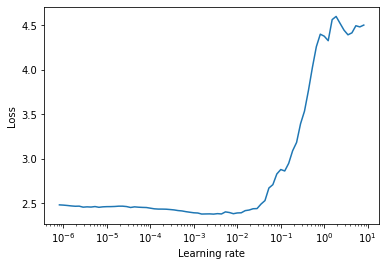

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-7,  momentum = 0.9)#weight_decay=1e-2)
lr_finder = LRFinder(net, optimizer, criterion, device)
lr_finder.range_test(trainloader, end_lr=100, num_iter=100)#, step_mode="exp")
lr_finder.plot()
lr_finder.reset()

In [19]:
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)#, weight_decay=1e-2)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')


In [20]:
from tqdm import tqdm
import train_new
import test

tr_acc = []
tr_loss = []

te_acc = []
te_loss = []

pbar = tqdm(trainloader)

for epoch in range(50):

  train_accuracy, train_loss = train_new.cifar10train(net, device, trainloader, optimizer, criterion, pbar)
  tr_acc.append(train_accuracy)
  tr_loss.append(train_loss)

  test_accuracy, test_loss = test.cifar10test(net, device, testloader, criterion)
  te_acc.append(test_accuracy)
  te_loss.append(test_loss)
  scheduler.step(test_loss)

  print('Epoch {} completed'.format(epoch+1))
  



loss=1.1578141450881958 batch_id=1562 Accuracy = 37.75:   0%|          | 0/1563 [00:58<?, ?it/s]


Train set: Average loss: 0.0535, Accuracy: 18876/50000 (37.75%)
Test set: Average loss:  0.041823225623369216  Accurcy:  52.26
Epoch 1 completed


loss=1.0965741872787476 batch_id=1562 Accuracy = 55.08:   0%|          | 0/1563 [02:01<?, ?it/s]


Train set: Average loss: 0.0394, Accuracy: 27541/50000 (55.08%)
Test set: Average loss:  0.02683092615902424  Accurcy:  69.89
Epoch 2 completed


loss=1.4201581478118896 batch_id=1562 Accuracy = 63.26:   0%|          | 0/1563 [03:04<?, ?it/s]


Train set: Average loss: 0.0327, Accuracy: 31629/50000 (63.26%)
Test set: Average loss:  0.026230318886041642  Accurcy:  72.23
Epoch 3 completed


loss=1.2036097049713135 batch_id=1562 Accuracy = 67.61:   0%|          | 0/1563 [04:07<?, ?it/s]


Train set: Average loss: 0.0289, Accuracy: 33803/50000 (67.61%)
Test set: Average loss:  0.02144252868592739  Accurcy:  76.68
Epoch 4 completed


loss=0.9862640500068665 batch_id=1562 Accuracy = 70.77:   0%|          | 0/1563 [05:10<?, ?it/s]


Train set: Average loss: 0.0262, Accuracy: 35383/50000 (70.77%)
Test set: Average loss:  0.018135280732810496  Accurcy:  80.38
Epoch 5 completed


loss=1.0122239589691162 batch_id=1562 Accuracy = 72.77:   0%|          | 0/1563 [06:13<?, ?it/s]


Train set: Average loss: 0.0243, Accuracy: 36385/50000 (72.77%)
Test set: Average loss:  0.01732868406623602  Accurcy:  81.14
Epoch 6 completed


loss=0.5042486190795898 batch_id=1562 Accuracy = 75.17:   0%|          | 0/1563 [07:15<?, ?it/s]


Train set: Average loss: 0.0225, Accuracy: 37584/50000 (75.17%)
Test set: Average loss:  0.01699448501318693  Accurcy:  81.11
Epoch 7 completed


loss=0.41292107105255127 batch_id=1562 Accuracy = 76.08:   0%|          | 0/1563 [08:18<?, ?it/s]


Train set: Average loss: 0.0214, Accuracy: 38039/50000 (76.08%)
Test set: Average loss:  0.015456889864802361  Accurcy:  83.11
Epoch 8 completed


loss=0.8832605481147766 batch_id=1562 Accuracy = 77.73:   0%|          | 0/1563 [09:20<?, ?it/s]


Train set: Average loss: 0.0200, Accuracy: 38866/50000 (77.73%)
Test set: Average loss:  0.014949004540592432  Accurcy:  84.07
Epoch 9 completed


loss=0.9165430068969727 batch_id=1562 Accuracy = 78.71:   0%|          | 0/1563 [10:22<?, ?it/s]


Train set: Average loss: 0.0191, Accuracy: 39355/50000 (78.71%)
Test set: Average loss:  0.015371275439113378  Accurcy:  83.69
Epoch 10 completed


loss=0.37427347898483276 batch_id=1562 Accuracy = 79.70:   0%|          | 0/1563 [11:25<?, ?it/s]


Train set: Average loss: 0.0180, Accuracy: 39850/50000 (79.70%)
Test set: Average loss:  0.014331759545207023  Accurcy:  84.35
Epoch 11 completed


loss=0.811555027961731 batch_id=1562 Accuracy = 80.64:   0%|          | 0/1563 [12:28<?, ?it/s] 


Train set: Average loss: 0.0174, Accuracy: 40321/50000 (80.64%)
Test set: Average loss:  0.012180875109881162  Accurcy:  86.34
Epoch 12 completed


loss=0.15308216214179993 batch_id=1562 Accuracy = 81.72:   0%|          | 0/1563 [13:31<?, ?it/s]


Train set: Average loss: 0.0165, Accuracy: 40858/50000 (81.72%)
Test set: Average loss:  0.01221104877591133  Accurcy:  87.18
Epoch 13 completed


loss=0.9653355479240417 batch_id=1562 Accuracy = 82.70:   0%|          | 0/1563 [14:34<?, ?it/s]


Train set: Average loss: 0.0155, Accuracy: 41352/50000 (82.70%)
Test set: Average loss:  0.01219687978029251  Accurcy:  86.97
Epoch 14 completed


loss=0.41514259576797485 batch_id=1562 Accuracy = 83.31:   0%|          | 0/1563 [15:37<?, ?it/s]


Train set: Average loss: 0.0150, Accuracy: 41657/50000 (83.31%)
Test set: Average loss:  0.01155862674191594  Accurcy:  88.0
Epoch 15 completed


loss=0.4297764003276825 batch_id=1562 Accuracy = 83.78:   0%|          | 0/1563 [16:40<?, ?it/s]


Train set: Average loss: 0.0146, Accuracy: 41889/50000 (83.78%)
Test set: Average loss:  0.011248953247815371  Accurcy:  87.79
Epoch 16 completed


loss=0.8776095509529114 batch_id=1562 Accuracy = 84.37:   0%|          | 0/1563 [17:43<?, ?it/s] 


Train set: Average loss: 0.0140, Accuracy: 42185/50000 (84.37%)
Test set: Average loss:  0.011251909528672695  Accurcy:  88.28
Epoch 17 completed


loss=0.5988708734512329 batch_id=1562 Accuracy = 84.93:   0%|          | 0/1563 [18:46<?, ?it/s] 


Train set: Average loss: 0.0134, Accuracy: 42465/50000 (84.93%)
Test set: Average loss:  0.010563320271670819  Accurcy:  88.77
Epoch 18 completed


loss=0.6091430187225342 batch_id=1562 Accuracy = 85.44:   0%|          | 0/1563 [19:49<?, ?it/s] 


Train set: Average loss: 0.0131, Accuracy: 42719/50000 (85.44%)
Test set: Average loss:  0.009871851629763841  Accurcy:  89.36
Epoch 19 completed


loss=0.6442185640335083 batch_id=1562 Accuracy = 85.90:   0%|          | 0/1563 [20:52<?, ?it/s]


Train set: Average loss: 0.0124, Accuracy: 42951/50000 (85.90%)
Test set: Average loss:  0.010225363446772098  Accurcy:  89.03
Epoch 20 completed


loss=0.25819510221481323 batch_id=1562 Accuracy = 86.42:   0%|          | 0/1563 [21:54<?, ?it/s]


Train set: Average loss: 0.0121, Accuracy: 43210/50000 (86.42%)
Test set: Average loss:  0.01057564777508378  Accurcy:  88.88
Epoch 21 completed


loss=0.36902472376823425 batch_id=1562 Accuracy = 86.86:   0%|          | 0/1563 [22:56<?, ?it/s]


Train set: Average loss: 0.0118, Accuracy: 43430/50000 (86.86%)
Test set: Average loss:  0.010354682499915361  Accurcy:  89.33
Epoch 22 completed


loss=0.4080231189727783 batch_id=1562 Accuracy = 87.44:   0%|          | 0/1563 [23:59<?, ?it/s] 


Train set: Average loss: 0.0113, Accuracy: 43718/50000 (87.44%)
Test set: Average loss:  0.009439145178347826  Accurcy:  90.04
Epoch 23 completed


loss=0.27495232224464417 batch_id=1562 Accuracy = 87.92:   0%|          | 0/1563 [25:01<?, ?it/s]


Train set: Average loss: 0.0109, Accuracy: 43959/50000 (87.92%)
Test set: Average loss:  0.009760023169219494  Accurcy:  89.68
Epoch 24 completed


loss=0.45836737751960754 batch_id=1562 Accuracy = 88.01:   0%|          | 0/1563 [26:03<?, ?it/s]


Train set: Average loss: 0.0107, Accuracy: 44006/50000 (88.01%)
Test set: Average loss:  0.009685204319655895  Accurcy:  90.1
Epoch 25 completed


loss=0.1678483635187149 batch_id=1562 Accuracy = 88.30:   0%|          | 0/1563 [27:06<?, ?it/s] 


Train set: Average loss: 0.0103, Accuracy: 44149/50000 (88.30%)
Test set: Average loss:  0.009411597726494074  Accurcy:  90.62
Epoch 26 completed


loss=0.08277252316474915 batch_id=1562 Accuracy = 88.99:   0%|          | 0/1563 [28:09<?, ?it/s]


Train set: Average loss: 0.0100, Accuracy: 44496/50000 (88.99%)
Test set: Average loss:  0.008938486733287574  Accurcy:  90.61
Epoch 27 completed


loss=0.19162225723266602 batch_id=1562 Accuracy = 88.90:   0%|          | 0/1563 [29:13<?, ?it/s]


Train set: Average loss: 0.0098, Accuracy: 44450/50000 (88.90%)
Test set: Average loss:  0.009073344898968935  Accurcy:  90.82
Epoch 28 completed


loss=0.27816060185432434 batch_id=1562 Accuracy = 89.26:   0%|          | 0/1563 [30:16<?, ?it/s]


Train set: Average loss: 0.0096, Accuracy: 44629/50000 (89.26%)
Test set: Average loss:  0.009775392536073924  Accurcy:  90.08
Epoch 29 completed


loss=0.3326532244682312 batch_id=1562 Accuracy = 89.58:   0%|          | 0/1563 [31:19<?, ?it/s]


Train set: Average loss: 0.0093, Accuracy: 44790/50000 (89.58%)
Test set: Average loss:  0.00877253115773201  Accurcy:  91.09
Epoch 30 completed


loss=0.6329162120819092 batch_id=1562 Accuracy = 90.03:   0%|          | 0/1563 [32:22<?, ?it/s] 


Train set: Average loss: 0.0090, Accuracy: 45013/50000 (90.03%)
Test set: Average loss:  0.009138831437379123  Accurcy:  90.84
Epoch 31 completed


loss=0.14679792523384094 batch_id=1562 Accuracy = 90.19:   0%|          | 0/1563 [33:25<?, ?it/s]


Train set: Average loss: 0.0088, Accuracy: 45095/50000 (90.19%)
Test set: Average loss:  0.008466504181176424  Accurcy:  91.51
Epoch 32 completed


loss=0.12020152807235718 batch_id=1562 Accuracy = 90.50:   0%|          | 0/1563 [34:28<?, ?it/s]


Train set: Average loss: 0.0085, Accuracy: 45248/50000 (90.50%)
Test set: Average loss:  0.008553302091360092  Accurcy:  91.47
Epoch 33 completed


loss=0.3584241271018982 batch_id=1562 Accuracy = 90.65:   0%|          | 0/1563 [35:30<?, ?it/s]


Train set: Average loss: 0.0084, Accuracy: 45325/50000 (90.65%)
Test set: Average loss:  0.009059361091256142  Accurcy:  91.2
Epoch 34 completed


loss=0.5826737284660339 batch_id=1562 Accuracy = 90.98:   0%|          | 0/1563 [36:33<?, ?it/s] 


Train set: Average loss: 0.0082, Accuracy: 45488/50000 (90.98%)
Test set: Average loss:  0.008555958846956492  Accurcy:  91.5
Epoch 35 completed


loss=0.3698887526988983 batch_id=1562 Accuracy = 91.07:   0%|          | 0/1563 [37:36<?, ?it/s]


Train set: Average loss: 0.0080, Accuracy: 45534/50000 (91.07%)
Test set: Average loss:  0.00835166229903698  Accurcy:  91.48
Epoch 36 completed


loss=0.3860602080821991 batch_id=1562 Accuracy = 91.47:   0%|          | 0/1563 [38:39<?, ?it/s] 


Train set: Average loss: 0.0077, Accuracy: 45736/50000 (91.47%)
Test set: Average loss:  0.008538506278395653  Accurcy:  91.72
Epoch 37 completed


loss=0.17500077188014984 batch_id=1562 Accuracy = 91.49:   0%|          | 0/1563 [39:43<?, ?it/s]


Train set: Average loss: 0.0076, Accuracy: 45744/50000 (91.49%)
Test set: Average loss:  0.008315060222893954  Accurcy:  91.93
Epoch 38 completed


loss=0.09290099143981934 batch_id=1562 Accuracy = 91.60:   0%|          | 0/1563 [40:46<?, ?it/s]


Train set: Average loss: 0.0075, Accuracy: 45800/50000 (91.60%)
Test set: Average loss:  0.00887424456179142  Accurcy:  91.3
Epoch 39 completed


loss=0.2714380621910095 batch_id=1562 Accuracy = 92.05:   0%|          | 0/1563 [41:50<?, ?it/s] 


Train set: Average loss: 0.0072, Accuracy: 46026/50000 (92.05%)
Test set: Average loss:  0.008952816806733608  Accurcy:  91.52
Epoch 40 completed


loss=0.36156681180000305 batch_id=1562 Accuracy = 91.96:   0%|          | 0/1563 [42:53<?, ?it/s]


Train set: Average loss: 0.0073, Accuracy: 45979/50000 (91.96%)
Test set: Average loss:  0.009278498106449842  Accurcy:  91.34
Epoch 41 completed


loss=0.17713168263435364 batch_id=1562 Accuracy = 92.17:   0%|          | 0/1563 [43:57<?, ?it/s]


Train set: Average loss: 0.0069, Accuracy: 46084/50000 (92.17%)
Test set: Average loss:  0.009155181704461574  Accurcy:  91.45
Epoch 42 completed


loss=0.024771124124526978 batch_id=1562 Accuracy = 92.38:   0%|          | 0/1563 [45:01<?, ?it/s]


Train set: Average loss: 0.0069, Accuracy: 46191/50000 (92.38%)
Test set: Average loss:  0.008493917039036751  Accurcy:  91.77
Epoch 43 completed


loss=0.04124104976654053 batch_id=1562 Accuracy = 92.60:   0%|          | 0/1563 [46:04<?, ?it/s]


Train set: Average loss: 0.0067, Accuracy: 46299/50000 (92.60%)
Test set: Average loss:  0.00839275832399726  Accurcy:  92.21
Epoch 44 completed


loss=0.2948891818523407 batch_id=1562 Accuracy = 92.41:   0%|          | 0/1563 [47:08<?, ?it/s] 


Train set: Average loss: 0.0067, Accuracy: 46206/50000 (92.41%)
Test set: Average loss:  0.008299232403934003  Accurcy:  91.88
Epoch 45 completed


loss=0.3019852638244629 batch_id=1562 Accuracy = 92.97:   0%|          | 0/1563 [48:12<?, ?it/s]


Train set: Average loss: 0.0064, Accuracy: 46483/50000 (92.97%)
Test set: Average loss:  0.008129787651449442  Accurcy:  92.22
Epoch 46 completed


loss=0.3458439111709595 batch_id=1562 Accuracy = 92.95:   0%|          | 0/1563 [49:16<?, ?it/s]


Train set: Average loss: 0.0063, Accuracy: 46474/50000 (92.95%)
Test set: Average loss:  0.008612265875190496  Accurcy:  92.1
Epoch 47 completed


loss=0.040592730045318604 batch_id=1562 Accuracy = 93.12:   0%|          | 0/1563 [50:20<?, ?it/s]


Train set: Average loss: 0.0062, Accuracy: 46559/50000 (93.12%)
Test set: Average loss:  0.008460034966468811  Accurcy:  92.1
Epoch 48 completed


loss=0.2749650180339813 batch_id=1562 Accuracy = 93.13:   0%|          | 0/1563 [51:25<?, ?it/s] 


Train set: Average loss: 0.0062, Accuracy: 46563/50000 (93.13%)
Test set: Average loss:  0.008784852230548859  Accurcy:  91.77
Epoch 49 completed


loss=0.2896170914173126 batch_id=1562 Accuracy = 93.51:   0%|          | 0/1563 [52:29<?, ?it/s] 


Train set: Average loss: 0.0059, Accuracy: 46755/50000 (93.51%)
Test set: Average loss:  0.008709357123076916  Accurcy:  91.72
Epoch 50 completed


In [21]:
torch.save(net, './save1')

In [ ]:
 #train_losses, train_accuracy

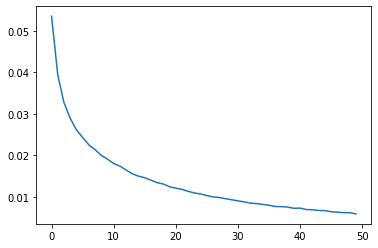

In [22]:
import matplotlib.pyplot as plt

plt.plot(tr_loss)

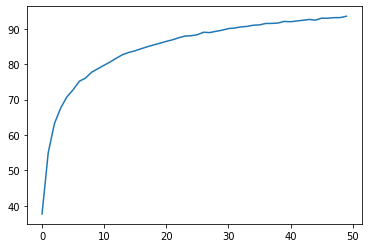

In [23]:
plt.plot(tr_acc)

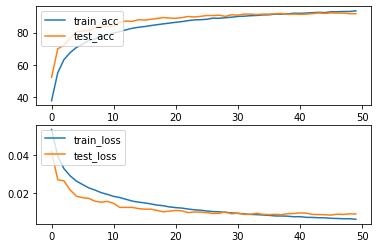

In [24]:
fig = plt.figure()

ax1 = plt.subplot2grid((2,1), (0,0))
ax2 = plt.subplot2grid((2,1), (1,0), sharex=ax1)


ax1.plot(tr_acc, label="train_acc")
ax1.plot(te_acc, label="test_acc")
ax1.legend(loc=2)
ax2.plot(tr_loss, label="train_loss")
ax2.plot(te_loss, label="test_loss")
ax2.legend(loc=2)
plt.show()

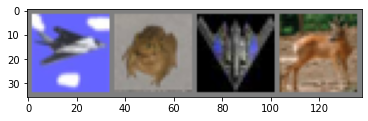

GroundTruth:  plane  frog plane  deer


In [25]:
dataiter = iter(testloader)
images, labels = dataiter.next()
#images = images.to(device)
#labels = labels.to(device)

# print images
imshow(torchvision.utils.make_grid(images[:4]))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [26]:
images = images[:4].to(device)
outputs = net(images)

In [27]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:  plane  frog  frog  deer


In [28]:
def calcMisClassification(model):
    count = 0
    correct = 0
    img_list = []
    pred_list = []
    target_list = []

    MAX_DIFF = 25

    with torch.no_grad():
        for data, target in testloader:
            correct += 1
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            for index in range(len(target.cpu().numpy())):
                if(pred[index].cpu().numpy()[0] != target[index].cpu().numpy()):
                    count += 1
                    img_list.append(data[index].cpu().numpy().squeeze())
                    pred_list.append(pred[index].cpu().numpy()[0])
                    target_list.append(target[index].cpu().numpy())
            if(count > MAX_DIFF):
                break
    return img_list, pred_list, target_list

In [31]:


def showMisClassification(img_list, pred_list, target_list, MAX_DIFF = 25):
    for index in range(MAX_DIFF):
        ax = plt.subplot(5,5, index+1)
        #plt.tight_layout()
        ax.axis('off')
        plt.title("Predicted: {}, Truth: {}".format(classes[pred_list[index]],classes[target_list[index]]))
        plt.imshow(np.transpose(img_list[index], (1, 2, 0)),interpolation='none')
        plt.show()



In [29]:
index = 0
net.eval()
img_list, pred_list, target_list = calcMisClassification(net)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


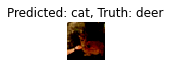

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


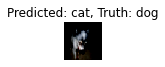

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


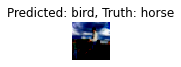

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


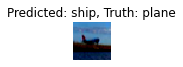

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


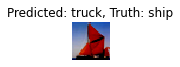

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


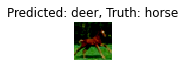

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


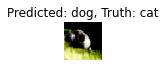

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


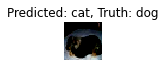

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


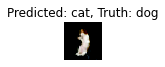

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


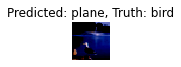

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


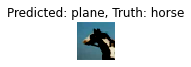

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


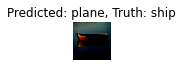

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


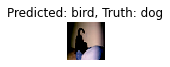

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


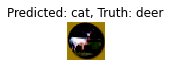

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


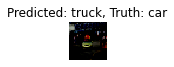

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


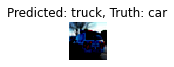

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


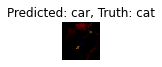

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


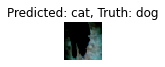

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


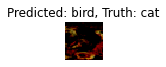

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


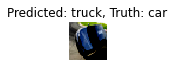

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


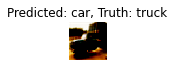

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


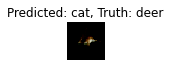

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


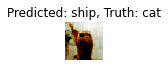

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


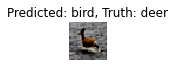

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


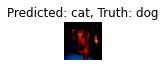

In [32]:
import numpy as np
showMisClassification(img_list, pred_list, target_list)

In [33]:
def imshow(img,c = "" ):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    fig = plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)),interpolation='none')
    plt.title(c)

In [34]:
def showGradCam(b, inputs, images1, images2, actual, predicted):
  layers =  [b.layer1,b.layer2,b.layer3,b.layer4]
  for j in layers:
    g = GradCAM(b,j)
    mask, _= g(inputs )
    heatmap, result = visualize_cam(mask,inputs )
    images1.extend([heatmap])
    images2.extend([result])
  grid_image = make_grid(images1+images2,nrow=5)
  imshow(grid_image,c = 'Truth:'+actual+' Predicted:'+predicted)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2796: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or 

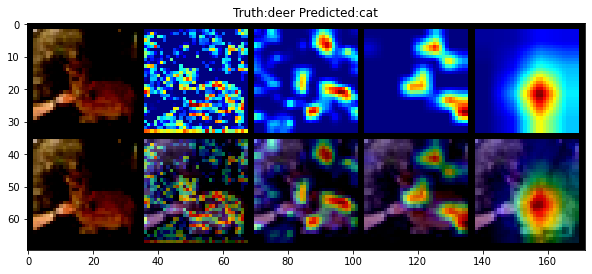

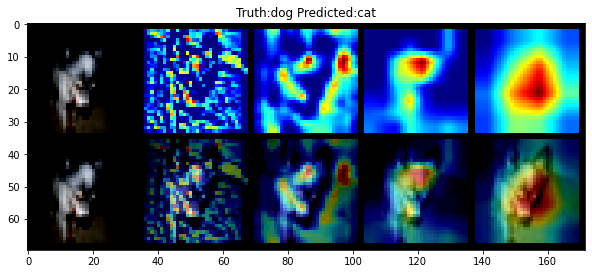

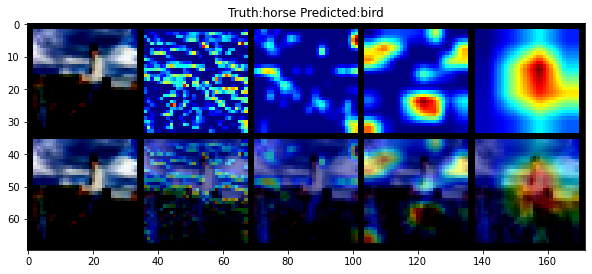

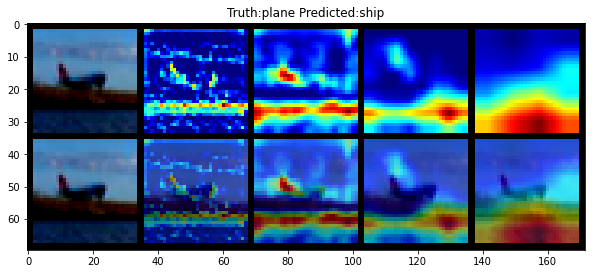

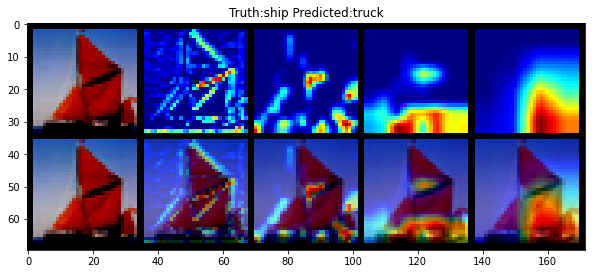

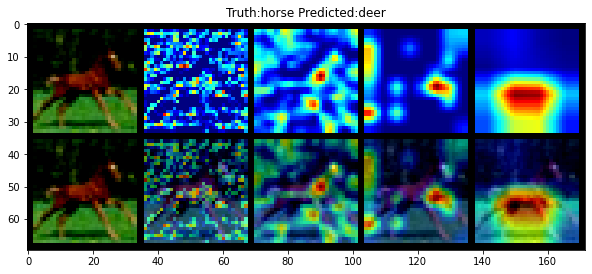

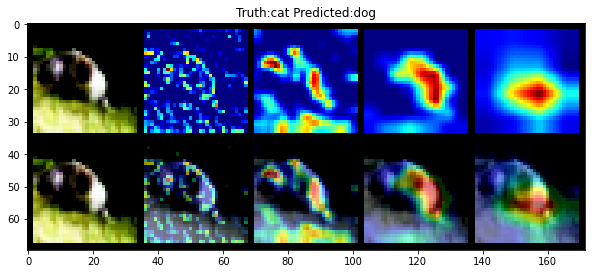

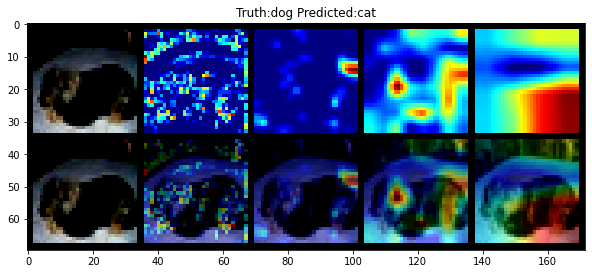

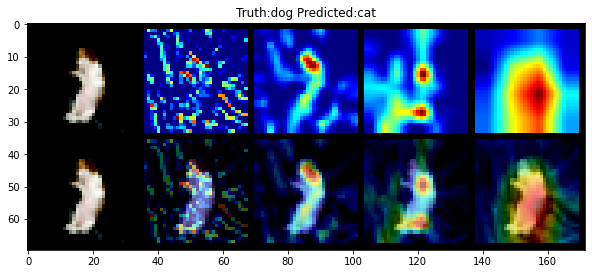

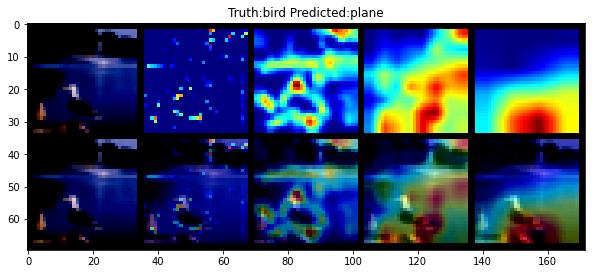

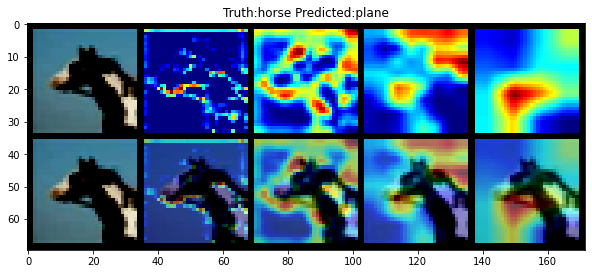

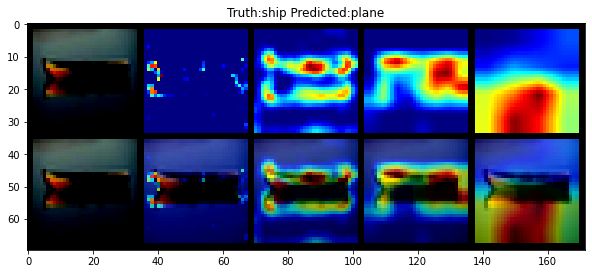

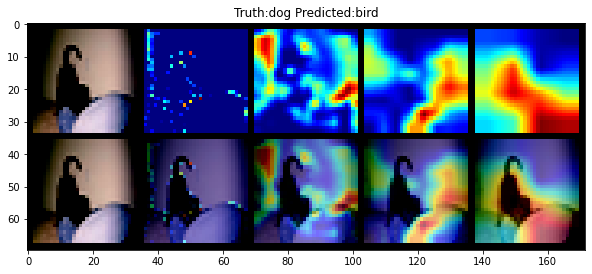

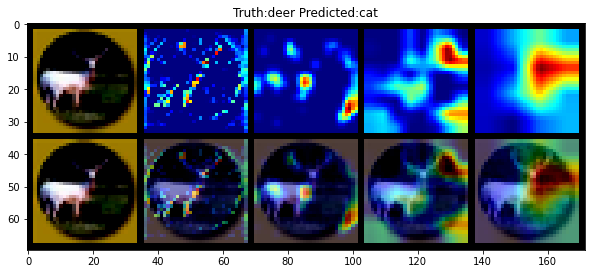

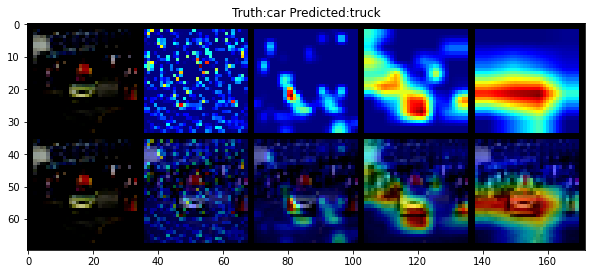

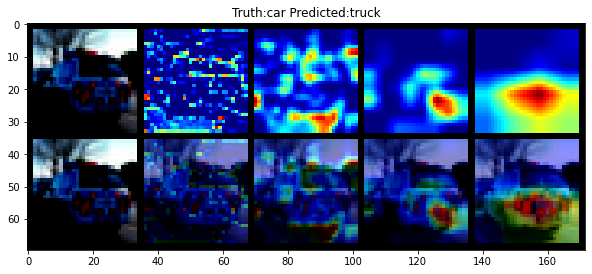

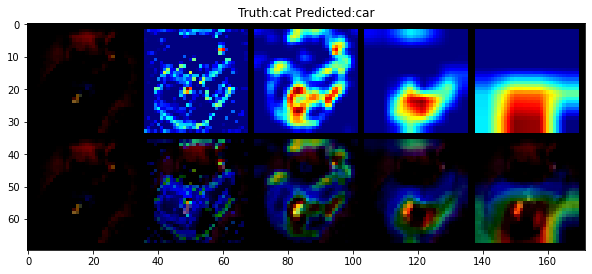

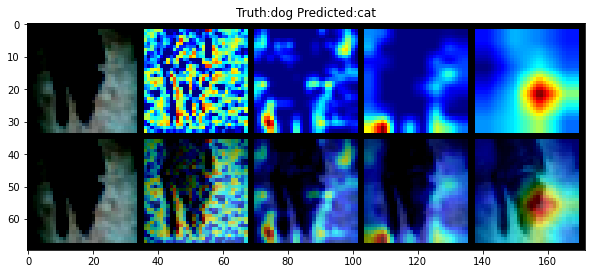

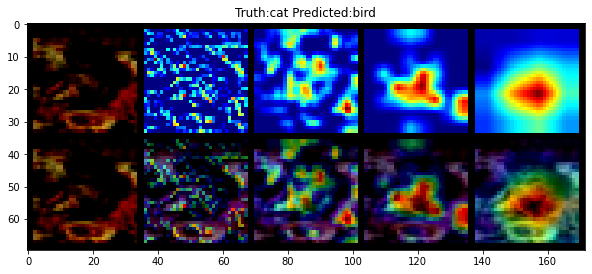

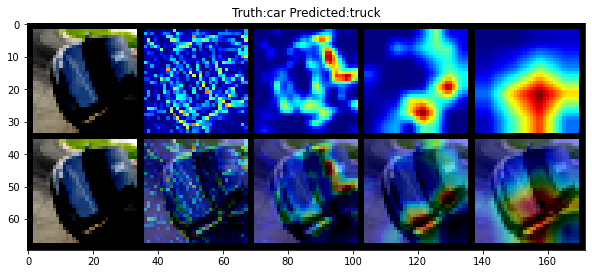

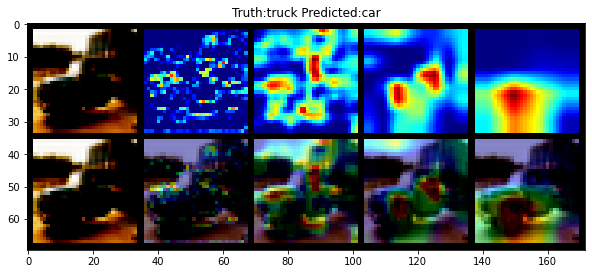

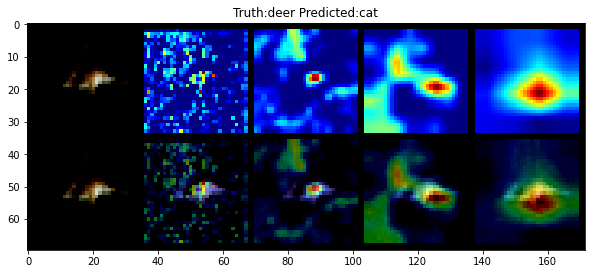

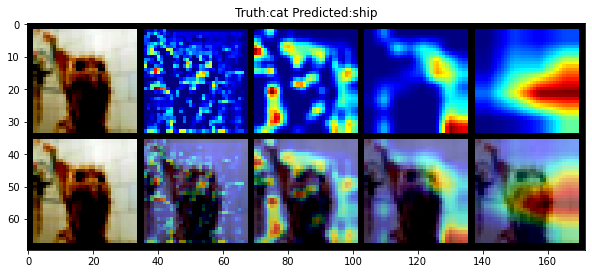

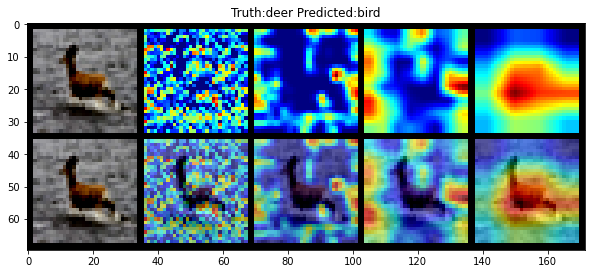

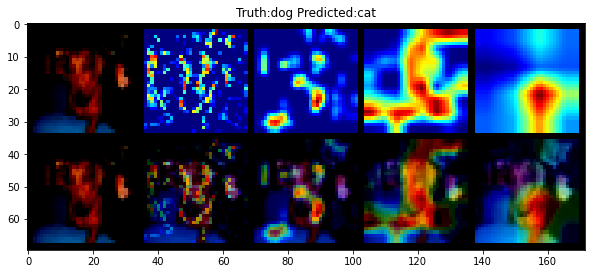

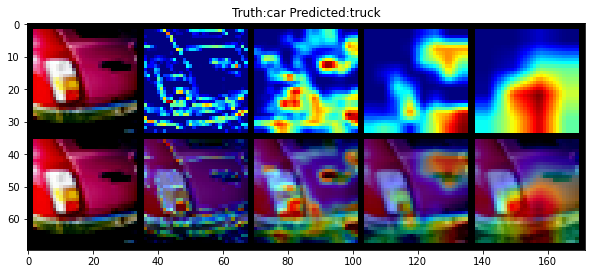

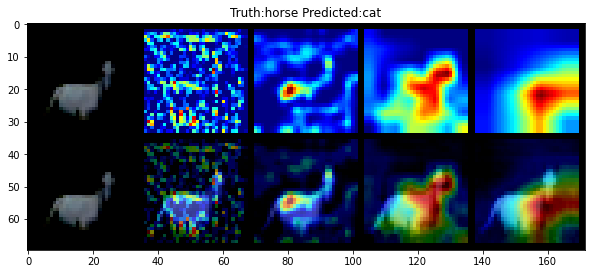

In [36]:
import copy
from torchvision.utils import make_grid, save_image
from gc2 import GradCAM,visualize_cam

for i,k in enumerate(img_list):
  images1 = [torch.FloatTensor(img_list[i])]#.cpu()]
  images2 =  [torch.FloatTensor(img_list[i])]#.cpu()]
  b = copy.deepcopy(net.to(device))
  b.eval()
  inputs = torch.FloatTensor(img_list[i]).to(device)
  inputs = inputs.unsqueeze(0)
  predicted = classes[int(pred_list[i])]
  actual = classes[int(target_list[i])]
  showGradCam(b, inputs, images1, images2, actual, predicted)
